In [17]:
import pandas as pd
import glob,os
import numpy as np
import pandas as pd 
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline

In [14]:
path = r'./COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'

In [15]:
def get_all_time_series():
    path = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    for i in [0,3,4]:
        file = all_files[i]
        df = pd.read_csv(file)
        #confirmed_all = dict()
        if i==0:
            df_confirmed = pd.DataFrame()
            for row in df.values:
                df_confirmed[row[1]] = row[4:]
        if i==3:
            df_recovered = pd.DataFrame()
            for row in df.values:
                df_recovered[row[1]] = row[4:]
        if i==4:
            df_deaths = pd.DataFrame()
            for row in df.values:
                df_deaths[row[1]] = row[4:]
    df_infected = df_confirmed - df_deaths - df_recovered
    return [df_infected,df_confirmed,df_recovered,df_deaths]

In [16]:
[df_infected,df_confirmed,df_recovered,df_deaths] = get_all_time_series()
us_infected = df_infected['US'].values
us_deaths = df_deaths['US'].values
us_recovered = df_recovered['US'].values

In [10]:
us_population = 327200000;
Regr = 70;

In [11]:
def solve_SIRD_discrete(num_times,beta_t,gamma_t,mu_t,s0,i0,r0,d0):
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    return [S,I,R,D]

In [12]:
i0 = us_infected[0]
r0 = 0
s0 = us_population - i0
#R1 = 3./100.
d0 = us_deaths[0]
num_times = len(us_deaths)

beta = 0.6345301162187955
gamma = 0.43979856466213035
mu = 0.006641658374541129

beta_0 = np.array([beta for i in range(num_times)])
gamma_0 = np.array([gamma for i in range(num_times)])
mu_0 = np.array([mu for i in range(num_times)])


print("beta={}\ngamma={}\nmu={}".format(beta,gamma,mu))

beta=0.6345301162187955
gamma=0.43979856466213035
mu=0.006641658374541129


In [88]:
@tf.function()
def tf_loss_fn_us(y_true, y_pred):
    beta_t = y_pred[0][:,0]
    gamma_t = y_pred[0][:,1]
    mu_t = y_pred[0][:,2]
    
    beta_0 = y_true[0][0,0]
    gamma_0 = y_true[0][0,1]
    mu_0 = y_true[0][0,2]
    
    S = []
    I = []
    R = []
    D = []

    S.append(s0)
    I.append(i0)
    R.append(r0)
    D.append(d0)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    I = tf.stack(I)
    D = tf.stack(D)
    epsilon = 0.000001
    Ed1 = tf.math.reduce_sum((tf.math.log((x_trains[0][:,0]+epsilon))-tf.math.log((I+epsilon)))**2 + (tf.math.log((x_trains[0][:,1]+epsilon))-tf.math.log((D+epsilon)))**2)
    
    Ed2 = 0.01*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/(tf.math.reduce_max(x_trains[0][:,0])+epsilon) * tf.math.reduce_sum((x_trains[0][:,0]-I)**2+ (x_trains[0][:,1]-D)**2)

    sumr = 0
    for it in range(num_times-1):
        sumr = sumr + (beta_t[it]-beta_t[it+1])**2 + (gamma_t[it]-gamma_t[it+1])**2 + 100*(mu_t[it]-mu_t[it+1])**2
    Er = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*sumr
    
    E0 = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*((beta_t[0]-beta_0)**2+(gamma_t[0]- gamma_0)**2 +100*(mu_t[0]-mu_0)**2)

    return Ed1+Ed2+Er+E0

In [89]:
num_times = len(us_deaths)

In [90]:
def to_float(x):
    return float(x)

to_float_vec = np.vectorize(to_float)

In [91]:
x_train = to_float_vec(np.array([us_infected[0:num_times],us_deaths[0:num_times]]).transpose())
num_times = len(x_train)

In [92]:
x_trains = to_float_vec(np.array([x_train]))

In [93]:
num_times

232

In [199]:
tf.keras.backend.set_floatx('float64')

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(num_times, 2)),
    tf.keras.layers.Dense(16,activation='sigmoid'),
    tf.keras.layers.Dense(num_times*3,activation = 'sigmoid'),
    tf.keras.layers.Reshape((num_times, 3))
])

In [200]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.012),
              loss = 'mean_squared_error',
              metrics=['accuracy']
             )

In [201]:
num_times = num_times
y_true = np.zeros((num_times,3))
y_true[:,0] = beta_0[0:num_times]
y_true[:,1] = gamma_0[0:num_times]
y_true[:,2] = mu_0[0:num_times]

y_trues = np.array([y_true])

In [202]:
model.fit(x_trains,y_trues,verbose=1,epochs=2500)

Epoch 1/2500
1/1 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.3491
Epoch 2/2500
1/1 [==============================] - 0s 502us/step - loss: 0.0788 - accuracy: 0.7672
Epoch 3/2500
1/1 [==============================] - 0s 489us/step - loss: 0.0696 - accuracy: 0.9440
Epoch 4/2500
1/1 [==============================] - 0s 486us/step - loss: 0.0615 - accuracy: 0.9914
Epoch 5/2500
1/1 [==============================] - 0s 842us/step - loss: 0.0544 - accuracy: 1.0000
Epoch 6/2500
1/1 [==============================] - 0s 544us/step - loss: 0.0481 - accuracy: 1.0000
Epoch 7/2500
1/1 [==============================] - 0s 543us/step - loss: 0.0426 - accuracy: 1.0000
Epoch 8/2500
1/1 [==============================] - 0s 453us/step - loss: 0.0378 - accuracy: 1.0000
Epoch 9/2500
1/1 [==============================] - 0s 472us/step - loss: 0.0335 - accuracy: 1.0000
Epoch 10/2500
1/1 [==============================] - 0s 463us/step - loss: 0.0297 - accuracy: 1.0000
E

1/1 [==============================] - 0s 468us/step - loss: 2.6374e-04 - accuracy: 1.0000
Epoch 159/2500
1/1 [==============================] - 0s 465us/step - loss: 2.6129e-04 - accuracy: 1.0000
Epoch 160/2500
1/1 [==============================] - 0s 462us/step - loss: 2.5887e-04 - accuracy: 1.0000
Epoch 161/2500
1/1 [==============================] - 0s 463us/step - loss: 2.5649e-04 - accuracy: 1.0000
Epoch 162/2500
1/1 [==============================] - 0s 480us/step - loss: 2.5414e-04 - accuracy: 1.0000
Epoch 163/2500
1/1 [==============================] - 0s 551us/step - loss: 2.5182e-04 - accuracy: 1.0000
Epoch 164/2500
1/1 [==============================] - 0s 467us/step - loss: 2.4953e-04 - accuracy: 1.0000
Epoch 165/2500
1/1 [==============================] - 0s 448us/step - loss: 2.4727e-04 - accuracy: 1.0000
Epoch 166/2500
1/1 [==============================] - 0s 571us/step - loss: 2.4504e-04 - accuracy: 1.0000
Epoch 167/2500
1/1 [==============================] - 0s 463u

1/1 [==============================] - 0s 466us/step - loss: 8.6565e-05 - accuracy: 1.0000
Epoch 313/2500
1/1 [==============================] - 0s 470us/step - loss: 8.6067e-05 - accuracy: 1.0000
Epoch 314/2500
1/1 [==============================] - 0s 472us/step - loss: 8.5572e-05 - accuracy: 1.0000
Epoch 315/2500
1/1 [==============================] - 0s 481us/step - loss: 8.5082e-05 - accuracy: 1.0000
Epoch 316/2500
1/1 [==============================] - 0s 484us/step - loss: 8.4596e-05 - accuracy: 1.0000
Epoch 317/2500
1/1 [==============================] - 0s 542us/step - loss: 8.4113e-05 - accuracy: 1.0000
Epoch 318/2500
1/1 [==============================] - 0s 680us/step - loss: 8.3634e-05 - accuracy: 1.0000
Epoch 319/2500
1/1 [==============================] - 0s 482us/step - loss: 8.3159e-05 - accuracy: 1.0000
Epoch 320/2500
1/1 [==============================] - 0s 680us/step - loss: 8.2688e-05 - accuracy: 1.0000
Epoch 321/2500
1/1 [==============================] - 0s 480u

1/1 [==============================] - 0s 476us/step - loss: 4.0101e-05 - accuracy: 1.0000
Epoch 467/2500
1/1 [==============================] - 0s 479us/step - loss: 3.9926e-05 - accuracy: 1.0000
Epoch 468/2500
1/1 [==============================] - 0s 471us/step - loss: 3.9751e-05 - accuracy: 1.0000
Epoch 469/2500
1/1 [==============================] - 0s 490us/step - loss: 3.9578e-05 - accuracy: 1.0000
Epoch 470/2500
1/1 [==============================] - 0s 509us/step - loss: 3.9405e-05 - accuracy: 1.0000
Epoch 471/2500
1/1 [==============================] - 0s 525us/step - loss: 3.9234e-05 - accuracy: 1.0000
Epoch 472/2500
1/1 [==============================] - 0s 480us/step - loss: 3.9064e-05 - accuracy: 1.0000
Epoch 473/2500
1/1 [==============================] - 0s 527us/step - loss: 3.8894e-05 - accuracy: 1.0000
Epoch 474/2500
1/1 [==============================] - 0s 489us/step - loss: 3.8726e-05 - accuracy: 1.0000
Epoch 475/2500
1/1 [==============================] - 0s 466u

1/1 [==============================] - 0s 467us/step - loss: 2.1674e-05 - accuracy: 1.0000
Epoch 621/2500
1/1 [==============================] - 0s 501us/step - loss: 2.1595e-05 - accuracy: 1.0000
Epoch 622/2500
1/1 [==============================] - 0s 489us/step - loss: 2.1516e-05 - accuracy: 1.0000
Epoch 623/2500
1/1 [==============================] - 0s 456us/step - loss: 2.1437e-05 - accuracy: 1.0000
Epoch 624/2500
1/1 [==============================] - 0s 469us/step - loss: 2.1359e-05 - accuracy: 1.0000
Epoch 625/2500
1/1 [==============================] - 0s 473us/step - loss: 2.1281e-05 - accuracy: 1.0000
Epoch 626/2500
1/1 [==============================] - 0s 484us/step - loss: 2.1203e-05 - accuracy: 1.0000
Epoch 627/2500
1/1 [==============================] - 0s 1ms/step - loss: 2.1126e-05 - accuracy: 1.0000
Epoch 628/2500
1/1 [==============================] - 0s 673us/step - loss: 2.1049e-05 - accuracy: 1.0000
Epoch 629/2500
1/1 [==============================] - 0s 504us/

1/1 [==============================] - 0s 490us/step - loss: 1.2750e-05 - accuracy: 1.0000
Epoch 775/2500
1/1 [==============================] - 0s 469us/step - loss: 1.2709e-05 - accuracy: 1.0000
Epoch 776/2500
1/1 [==============================] - 0s 478us/step - loss: 1.2668e-05 - accuracy: 1.0000
Epoch 777/2500
1/1 [==============================] - 0s 615us/step - loss: 1.2627e-05 - accuracy: 1.0000
Epoch 778/2500
1/1 [==============================] - 0s 477us/step - loss: 1.2586e-05 - accuracy: 1.0000
Epoch 779/2500
1/1 [==============================] - 0s 484us/step - loss: 1.2545e-05 - accuracy: 1.0000
Epoch 780/2500
1/1 [==============================] - 0s 463us/step - loss: 1.2504e-05 - accuracy: 1.0000
Epoch 781/2500
1/1 [==============================] - 0s 472us/step - loss: 1.2464e-05 - accuracy: 1.0000
Epoch 782/2500
1/1 [==============================] - 0s 455us/step - loss: 1.2424e-05 - accuracy: 1.0000
Epoch 783/2500
1/1 [==============================] - 0s 595u

1/1 [==============================] - 0s 513us/step - loss: 7.8951e-06 - accuracy: 1.0000
Epoch 929/2500
1/1 [==============================] - 0s 465us/step - loss: 7.8715e-06 - accuracy: 1.0000
Epoch 930/2500
1/1 [==============================] - 0s 575us/step - loss: 7.8480e-06 - accuracy: 1.0000
Epoch 931/2500
1/1 [==============================] - 0s 475us/step - loss: 7.8246e-06 - accuracy: 1.0000
Epoch 932/2500
1/1 [==============================] - 0s 1ms/step - loss: 7.8013e-06 - accuracy: 1.0000
Epoch 933/2500
1/1 [==============================] - 0s 478us/step - loss: 7.7780e-06 - accuracy: 1.0000
Epoch 934/2500
1/1 [==============================] - 0s 468us/step - loss: 7.7548e-06 - accuracy: 1.0000
Epoch 935/2500
1/1 [==============================] - 0s 457us/step - loss: 7.7317e-06 - accuracy: 1.0000
Epoch 936/2500
1/1 [==============================] - 0s 502us/step - loss: 7.7087e-06 - accuracy: 1.0000
Epoch 937/2500
1/1 [==============================] - 0s 538us/

1/1 [==============================] - 0s 515us/step - loss: 5.0635e-06 - accuracy: 1.0000
Epoch 1082/2500
1/1 [==============================] - 0s 594us/step - loss: 5.0492e-06 - accuracy: 1.0000
Epoch 1083/2500
1/1 [==============================] - 0s 484us/step - loss: 5.0349e-06 - accuracy: 1.0000
Epoch 1084/2500
1/1 [==============================] - 0s 479us/step - loss: 5.0207e-06 - accuracy: 1.0000
Epoch 1085/2500
1/1 [==============================] - 0s 487us/step - loss: 5.0066e-06 - accuracy: 1.0000
Epoch 1086/2500
1/1 [==============================] - 0s 661us/step - loss: 4.9924e-06 - accuracy: 1.0000
Epoch 1087/2500
1/1 [==============================] - 0s 499us/step - loss: 4.9784e-06 - accuracy: 1.0000
Epoch 1088/2500
1/1 [==============================] - 0s 460us/step - loss: 4.9644e-06 - accuracy: 1.0000
Epoch 1089/2500
1/1 [==============================] - 0s 708us/step - loss: 4.9504e-06 - accuracy: 1.0000
Epoch 1090/2500
1/1 [==============================] 

1/1 [==============================] - 0s 530us/step - loss: 3.3518e-06 - accuracy: 1.0000
Epoch 1234/2500
1/1 [==============================] - 0s 540us/step - loss: 3.3511e-06 - accuracy: 1.0000
Epoch 1235/2500
1/1 [==============================] - 0s 478us/step - loss: 3.3337e-06 - accuracy: 1.0000
Epoch 1236/2500
1/1 [==============================] - 0s 474us/step - loss: 3.3036e-06 - accuracy: 1.0000
Epoch 1237/2500
1/1 [==============================] - 0s 498us/step - loss: 3.2885e-06 - accuracy: 1.0000
Epoch 1238/2500
1/1 [==============================] - 0s 483us/step - loss: 3.2923e-06 - accuracy: 1.0000
Epoch 1239/2500
1/1 [==============================] - 0s 494us/step - loss: 3.2876e-06 - accuracy: 1.0000
Epoch 1240/2500
1/1 [==============================] - 0s 488us/step - loss: 3.2656e-06 - accuracy: 1.0000
Epoch 1241/2500
1/1 [==============================] - 0s 477us/step - loss: 3.2520e-06 - accuracy: 1.0000
Epoch 1242/2500
1/1 [==============================] 

1/1 [==============================] - 0s 471us/step - loss: 2.2057e-06 - accuracy: 1.0000
Epoch 1386/2500
1/1 [==============================] - 0s 492us/step - loss: 2.2047e-06 - accuracy: 1.0000
Epoch 1387/2500
1/1 [==============================] - 0s 494us/step - loss: 2.2001e-06 - accuracy: 1.0000
Epoch 1388/2500
1/1 [==============================] - 0s 472us/step - loss: 2.1892e-06 - accuracy: 1.0000
Epoch 1389/2500
1/1 [==============================] - 0s 548us/step - loss: 2.1828e-06 - accuracy: 1.0000
Epoch 1390/2500
1/1 [==============================] - 0s 658us/step - loss: 2.1807e-06 - accuracy: 1.0000
Epoch 1391/2500
1/1 [==============================] - 0s 531us/step - loss: 2.1736e-06 - accuracy: 1.0000
Epoch 1392/2500
1/1 [==============================] - 0s 596us/step - loss: 2.1647e-06 - accuracy: 1.0000
Epoch 1393/2500
1/1 [==============================] - 0s 731us/step - loss: 2.1605e-06 - accuracy: 1.0000
Epoch 1394/2500
1/1 [==============================] 

1/1 [==============================] - 0s 518us/step - loss: 1.4723e-06 - accuracy: 1.0000
Epoch 1538/2500
1/1 [==============================] - 0s 491us/step - loss: 1.4684e-06 - accuracy: 1.0000
Epoch 1539/2500
1/1 [==============================] - 0s 464us/step - loss: 1.4646e-06 - accuracy: 1.0000
Epoch 1540/2500
1/1 [==============================] - 0s 465us/step - loss: 1.4607e-06 - accuracy: 1.0000
Epoch 1541/2500
1/1 [==============================] - 0s 472us/step - loss: 1.4568e-06 - accuracy: 1.0000
Epoch 1542/2500
1/1 [==============================] - 0s 480us/step - loss: 1.4530e-06 - accuracy: 1.0000
Epoch 1543/2500
1/1 [==============================] - 0s 564us/step - loss: 1.4491e-06 - accuracy: 1.0000
Epoch 1544/2500
1/1 [==============================] - 0s 566us/step - loss: 1.4453e-06 - accuracy: 1.0000
Epoch 1545/2500
1/1 [==============================] - 0s 552us/step - loss: 1.4415e-06 - accuracy: 1.0000
Epoch 1546/2500
1/1 [==============================] 

1/1 [==============================] - 0s 650us/step - loss: 1.0178e-06 - accuracy: 1.0000
Epoch 1690/2500
1/1 [==============================] - 0s 470us/step - loss: 1.0211e-06 - accuracy: 1.0000
Epoch 1691/2500
1/1 [==============================] - 0s 583us/step - loss: 1.0042e-06 - accuracy: 1.0000
Epoch 1692/2500
1/1 [==============================] - 0s 988us/step - loss: 9.7950e-07 - accuracy: 1.0000
Epoch 1693/2500
1/1 [==============================] - 0s 706us/step - loss: 9.7682e-07 - accuracy: 1.0000
Epoch 1694/2500
1/1 [==============================] - 0s 670us/step - loss: 9.8944e-07 - accuracy: 1.0000
Epoch 1695/2500
1/1 [==============================] - 0s 477us/step - loss: 9.8657e-07 - accuracy: 1.0000
Epoch 1696/2500
1/1 [==============================] - 0s 571us/step - loss: 9.6911e-07 - accuracy: 1.0000
Epoch 1697/2500
1/1 [==============================] - 0s 632us/step - loss: 9.6519e-07 - accuracy: 1.0000
Epoch 1698/2500
1/1 [==============================] 

1/1 [==============================] - 0s 469us/step - loss: 6.5559e-07 - accuracy: 1.0000
Epoch 1842/2500
1/1 [==============================] - 0s 504us/step - loss: 6.5843e-07 - accuracy: 1.0000
Epoch 1843/2500
1/1 [==============================] - 0s 490us/step - loss: 6.6121e-07 - accuracy: 1.0000
Epoch 1844/2500
1/1 [==============================] - 0s 480us/step - loss: 6.5363e-07 - accuracy: 1.0000
Epoch 1845/2500
1/1 [==============================] - 0s 481us/step - loss: 6.4846e-07 - accuracy: 1.0000
Epoch 1846/2500
1/1 [==============================] - 0s 500us/step - loss: 6.5139e-07 - accuracy: 1.0000
Epoch 1847/2500
1/1 [==============================] - 0s 485us/step - loss: 6.5046e-07 - accuracy: 1.0000
Epoch 1848/2500
1/1 [==============================] - 0s 660us/step - loss: 6.4404e-07 - accuracy: 1.0000
Epoch 1849/2500
1/1 [==============================] - 0s 525us/step - loss: 6.4230e-07 - accuracy: 1.0000
Epoch 1850/2500
1/1 [==============================] 

1/1 [==============================] - 0s 602us/step - loss: 4.3639e-07 - accuracy: 1.0000
Epoch 1994/2500
1/1 [==============================] - 0s 631us/step - loss: 4.4534e-07 - accuracy: 1.0000
Epoch 1995/2500
1/1 [==============================] - 0s 539us/step - loss: 4.6194e-07 - accuracy: 1.0000
Epoch 1996/2500
1/1 [==============================] - 0s 680us/step - loss: 4.6092e-07 - accuracy: 1.0000
Epoch 1997/2500
1/1 [==============================] - 0s 633us/step - loss: 4.5677e-07 - accuracy: 1.0000
Epoch 1998/2500
1/1 [==============================] - 0s 541us/step - loss: 4.6933e-07 - accuracy: 1.0000
Epoch 1999/2500
1/1 [==============================] - 0s 694us/step - loss: 4.7407e-07 - accuracy: 1.0000
Epoch 2000/2500
1/1 [==============================] - 0s 646us/step - loss: 4.5007e-07 - accuracy: 1.0000
Epoch 2001/2500
1/1 [==============================] - 0s 707us/step - loss: 4.2692e-07 - accuracy: 1.0000
Epoch 2002/2500
1/1 [==============================] 

1/1 [==============================] - 0s 482us/step - loss: 2.9272e-07 - accuracy: 1.0000
Epoch 2146/2500
1/1 [==============================] - 0s 490us/step - loss: 2.8678e-07 - accuracy: 1.0000
Epoch 2147/2500
1/1 [==============================] - 0s 476us/step - loss: 2.8277e-07 - accuracy: 1.0000
Epoch 2148/2500
1/1 [==============================] - 0s 478us/step - loss: 2.8620e-07 - accuracy: 1.0000
Epoch 2149/2500
1/1 [==============================] - 0s 455us/step - loss: 2.8587e-07 - accuracy: 1.0000
Epoch 2150/2500
1/1 [==============================] - 0s 462us/step - loss: 2.8080e-07 - accuracy: 1.0000
Epoch 2151/2500
1/1 [==============================] - 0s 479us/step - loss: 2.8045e-07 - accuracy: 1.0000
Epoch 2152/2500
1/1 [==============================] - 0s 526us/step - loss: 2.8240e-07 - accuracy: 1.0000
Epoch 2153/2500
1/1 [==============================] - 0s 490us/step - loss: 2.7974e-07 - accuracy: 1.0000
Epoch 2154/2500
1/1 [==============================] 

1/1 [==============================] - 0s 447us/step - loss: 1.9390e-07 - accuracy: 1.0000
Epoch 2298/2500
1/1 [==============================] - 0s 538us/step - loss: 2.0597e-07 - accuracy: 1.0000
Epoch 2299/2500
1/1 [==============================] - 0s 500us/step - loss: 2.1728e-07 - accuracy: 1.0000
Epoch 2300/2500
1/1 [==============================] - 0s 474us/step - loss: 2.3523e-07 - accuracy: 1.0000
Epoch 2301/2500
1/1 [==============================] - 0s 521us/step - loss: 2.5788e-07 - accuracy: 1.0000
Epoch 2302/2500
1/1 [==============================] - 0s 497us/step - loss: 2.6349e-07 - accuracy: 1.0000
Epoch 2303/2500
1/1 [==============================] - 0s 472us/step - loss: 2.4157e-07 - accuracy: 1.0000
Epoch 2304/2500
1/1 [==============================] - 0s 492us/step - loss: 2.2127e-07 - accuracy: 1.0000
Epoch 2305/2500
1/1 [==============================] - 0s 491us/step - loss: 2.1915e-07 - accuracy: 1.0000
Epoch 2306/2500
1/1 [==============================] 

1/1 [==============================] - 0s 454us/step - loss: 2.0811e-07 - accuracy: 1.0000
Epoch 2450/2500
1/1 [==============================] - 0s 472us/step - loss: 4.1787e-07 - accuracy: 1.0000
Epoch 2451/2500
1/1 [==============================] - 0s 465us/step - loss: 1.9259e-07 - accuracy: 1.0000
Epoch 2452/2500
1/1 [==============================] - 0s 788us/step - loss: 3.2520e-07 - accuracy: 1.0000
Epoch 2453/2500
1/1 [==============================] - 0s 704us/step - loss: 2.0242e-07 - accuracy: 1.0000
Epoch 2454/2500
1/1 [==============================] - 0s 941us/step - loss: 2.4444e-07 - accuracy: 1.0000
Epoch 2455/2500
1/1 [==============================] - 0s 488us/step - loss: 2.5062e-07 - accuracy: 1.0000
Epoch 2456/2500
1/1 [==============================] - 0s 568us/step - loss: 1.5123e-07 - accuracy: 1.0000
Epoch 2457/2500
1/1 [==============================] - 0s 505us/step - loss: 2.5895e-07 - accuracy: 1.0000
Epoch 2458/2500
1/1 [==============================] 

In [203]:
model(np.array([x_train]))[0]

<tf.Tensor: shape=(232, 3), dtype=float64, numpy=
array([[0.63453012, 0.43979856, 0.00727857],
       [0.63453012, 0.44145233, 0.00702792],
       [0.63453012, 0.43979856, 0.00709501],
       [0.63453012, 0.43979856, 0.00714958],
       [0.63453012, 0.43958838, 0.00715653],
       [0.63453012, 0.43979856, 0.00699652],
       [0.63453012, 0.43979856, 0.00731141],
       [0.63453012, 0.43979856, 0.00717581],
       [0.63453012, 0.43979856, 0.00718862],
       [0.63453012, 0.43979856, 0.00739248],
       [0.63453012, 0.43979856, 0.00722901],
       [0.63453012, 0.43979856, 0.00727139],
       [0.63453012, 0.43979856, 0.00716901],
       [0.63453012, 0.43979856, 0.00703025],
       [0.63453012, 0.43979856, 0.00719779],
       [0.63453012, 0.43996308, 0.00745564],
       [0.63453012, 0.43979856, 0.00714492],
       [0.63453012, 0.43979856, 0.00717959],
       [0.63453012, 0.43979856, 0.00721869],
       [0.63453012, 0.43979856, 0.00694466],
       [0.63453012, 0.43979856, 0.00712741],
     

In [204]:
tf.config.experimental_run_functions_eagerly(False)

In [207]:
images = x_trains;
labels = y_trues

In [208]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(x_trains, training=True)
    
        # Add asserts to check the shape of the output.
        #tf.debugging.assert_equal(logits.shape, (32, 10))
    
        loss_value = loss_object(labels, logits)
    loss_history.append(loss_value)
    grads = tape.gradient(loss_value, model.trainable_variables)
    #print(grads)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),experimental_aggregate_gradients=True)


In [209]:
def train(epochs):
    for epoch in range(epochs):
        train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))


In [211]:
loss_history = []

In [295]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
loss_object = tf_loss_fn_us
train(epochs =5000)
np_loss_history = []
for loss in loss_history:
    np_loss_history.append(loss.numpy())

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished
Epoch 30 finished
Epoch 31 finished
Epoch 32 finished
Epoch 33 finished
Epoch 34 finished
Epoch 35 finished
Epoch 36 finished
Epoch 37 finished
Epoch 38 finished
Epoch 39 finished
Epoch 40 finished
Epoch 41 finished
Epoch 42 finished
Epoch 43 finished
Epoch 44 finished
Epoch 45 finished
Epoch 46 finished
Epoch 47 finished
Epoch 48 finished
Epoch 49 finished
Epoch 50 finished
Epoch 51 finished
Epoch 52 finished
Epoch 53 finished
Epoch 54 finished
Epoch 55 finished
Ep

Epoch 437 finished
Epoch 438 finished
Epoch 439 finished
Epoch 440 finished
Epoch 441 finished
Epoch 442 finished
Epoch 443 finished
Epoch 444 finished
Epoch 445 finished
Epoch 446 finished
Epoch 447 finished
Epoch 448 finished
Epoch 449 finished
Epoch 450 finished
Epoch 451 finished
Epoch 452 finished
Epoch 453 finished
Epoch 454 finished
Epoch 455 finished
Epoch 456 finished
Epoch 457 finished
Epoch 458 finished
Epoch 459 finished
Epoch 460 finished
Epoch 461 finished
Epoch 462 finished
Epoch 463 finished
Epoch 464 finished
Epoch 465 finished
Epoch 466 finished
Epoch 467 finished
Epoch 468 finished
Epoch 469 finished
Epoch 470 finished
Epoch 471 finished
Epoch 472 finished
Epoch 473 finished
Epoch 474 finished
Epoch 475 finished
Epoch 476 finished
Epoch 477 finished
Epoch 478 finished
Epoch 479 finished
Epoch 480 finished
Epoch 481 finished
Epoch 482 finished
Epoch 483 finished
Epoch 484 finished
Epoch 485 finished
Epoch 486 finished
Epoch 487 finished
Epoch 488 finished
Epoch 489 fi

Epoch 869 finished
Epoch 870 finished
Epoch 871 finished
Epoch 872 finished
Epoch 873 finished
Epoch 874 finished
Epoch 875 finished
Epoch 876 finished
Epoch 877 finished
Epoch 878 finished
Epoch 879 finished
Epoch 880 finished
Epoch 881 finished
Epoch 882 finished
Epoch 883 finished
Epoch 884 finished
Epoch 885 finished
Epoch 886 finished
Epoch 887 finished
Epoch 888 finished
Epoch 889 finished
Epoch 890 finished
Epoch 891 finished
Epoch 892 finished
Epoch 893 finished
Epoch 894 finished
Epoch 895 finished
Epoch 896 finished
Epoch 897 finished
Epoch 898 finished
Epoch 899 finished
Epoch 900 finished
Epoch 901 finished
Epoch 902 finished
Epoch 903 finished
Epoch 904 finished
Epoch 905 finished
Epoch 906 finished
Epoch 907 finished
Epoch 908 finished
Epoch 909 finished
Epoch 910 finished
Epoch 911 finished
Epoch 912 finished
Epoch 913 finished
Epoch 914 finished
Epoch 915 finished
Epoch 916 finished
Epoch 917 finished
Epoch 918 finished
Epoch 919 finished
Epoch 920 finished
Epoch 921 fi

Epoch 1288 finished
Epoch 1289 finished
Epoch 1290 finished
Epoch 1291 finished
Epoch 1292 finished
Epoch 1293 finished
Epoch 1294 finished
Epoch 1295 finished
Epoch 1296 finished
Epoch 1297 finished
Epoch 1298 finished
Epoch 1299 finished
Epoch 1300 finished
Epoch 1301 finished
Epoch 1302 finished
Epoch 1303 finished
Epoch 1304 finished
Epoch 1305 finished
Epoch 1306 finished
Epoch 1307 finished
Epoch 1308 finished
Epoch 1309 finished
Epoch 1310 finished
Epoch 1311 finished
Epoch 1312 finished
Epoch 1313 finished
Epoch 1314 finished
Epoch 1315 finished
Epoch 1316 finished
Epoch 1317 finished
Epoch 1318 finished
Epoch 1319 finished
Epoch 1320 finished
Epoch 1321 finished
Epoch 1322 finished
Epoch 1323 finished
Epoch 1324 finished
Epoch 1325 finished
Epoch 1326 finished
Epoch 1327 finished
Epoch 1328 finished
Epoch 1329 finished
Epoch 1330 finished
Epoch 1331 finished
Epoch 1332 finished
Epoch 1333 finished
Epoch 1334 finished
Epoch 1335 finished
Epoch 1336 finished
Epoch 1337 finished


Epoch 1699 finished
Epoch 1700 finished
Epoch 1701 finished
Epoch 1702 finished
Epoch 1703 finished
Epoch 1704 finished
Epoch 1705 finished
Epoch 1706 finished
Epoch 1707 finished
Epoch 1708 finished
Epoch 1709 finished
Epoch 1710 finished
Epoch 1711 finished
Epoch 1712 finished
Epoch 1713 finished
Epoch 1714 finished
Epoch 1715 finished
Epoch 1716 finished
Epoch 1717 finished
Epoch 1718 finished
Epoch 1719 finished
Epoch 1720 finished
Epoch 1721 finished
Epoch 1722 finished
Epoch 1723 finished
Epoch 1724 finished
Epoch 1725 finished
Epoch 1726 finished
Epoch 1727 finished
Epoch 1728 finished
Epoch 1729 finished
Epoch 1730 finished
Epoch 1731 finished
Epoch 1732 finished
Epoch 1733 finished
Epoch 1734 finished
Epoch 1735 finished
Epoch 1736 finished
Epoch 1737 finished
Epoch 1738 finished
Epoch 1739 finished
Epoch 1740 finished
Epoch 1741 finished
Epoch 1742 finished
Epoch 1743 finished
Epoch 1744 finished
Epoch 1745 finished
Epoch 1746 finished
Epoch 1747 finished
Epoch 1748 finished


Epoch 2110 finished
Epoch 2111 finished
Epoch 2112 finished
Epoch 2113 finished
Epoch 2114 finished
Epoch 2115 finished
Epoch 2116 finished
Epoch 2117 finished
Epoch 2118 finished
Epoch 2119 finished
Epoch 2120 finished
Epoch 2121 finished
Epoch 2122 finished
Epoch 2123 finished
Epoch 2124 finished
Epoch 2125 finished
Epoch 2126 finished
Epoch 2127 finished
Epoch 2128 finished
Epoch 2129 finished
Epoch 2130 finished
Epoch 2131 finished
Epoch 2132 finished
Epoch 2133 finished
Epoch 2134 finished
Epoch 2135 finished
Epoch 2136 finished
Epoch 2137 finished
Epoch 2138 finished
Epoch 2139 finished
Epoch 2140 finished
Epoch 2141 finished
Epoch 2142 finished
Epoch 2143 finished
Epoch 2144 finished
Epoch 2145 finished
Epoch 2146 finished
Epoch 2147 finished
Epoch 2148 finished
Epoch 2149 finished
Epoch 2150 finished
Epoch 2151 finished
Epoch 2152 finished
Epoch 2153 finished
Epoch 2154 finished
Epoch 2155 finished
Epoch 2156 finished
Epoch 2157 finished
Epoch 2158 finished
Epoch 2159 finished


Epoch 2521 finished
Epoch 2522 finished
Epoch 2523 finished
Epoch 2524 finished
Epoch 2525 finished
Epoch 2526 finished
Epoch 2527 finished
Epoch 2528 finished
Epoch 2529 finished
Epoch 2530 finished
Epoch 2531 finished
Epoch 2532 finished
Epoch 2533 finished
Epoch 2534 finished
Epoch 2535 finished
Epoch 2536 finished
Epoch 2537 finished
Epoch 2538 finished
Epoch 2539 finished
Epoch 2540 finished
Epoch 2541 finished
Epoch 2542 finished
Epoch 2543 finished
Epoch 2544 finished
Epoch 2545 finished
Epoch 2546 finished
Epoch 2547 finished
Epoch 2548 finished
Epoch 2549 finished
Epoch 2550 finished
Epoch 2551 finished
Epoch 2552 finished
Epoch 2553 finished
Epoch 2554 finished
Epoch 2555 finished
Epoch 2556 finished
Epoch 2557 finished
Epoch 2558 finished
Epoch 2559 finished
Epoch 2560 finished
Epoch 2561 finished
Epoch 2562 finished
Epoch 2563 finished
Epoch 2564 finished
Epoch 2565 finished
Epoch 2566 finished
Epoch 2567 finished
Epoch 2568 finished
Epoch 2569 finished
Epoch 2570 finished


Epoch 2933 finished
Epoch 2934 finished
Epoch 2935 finished
Epoch 2936 finished
Epoch 2937 finished
Epoch 2938 finished
Epoch 2939 finished
Epoch 2940 finished
Epoch 2941 finished
Epoch 2942 finished
Epoch 2943 finished
Epoch 2944 finished
Epoch 2945 finished
Epoch 2946 finished
Epoch 2947 finished
Epoch 2948 finished
Epoch 2949 finished
Epoch 2950 finished
Epoch 2951 finished
Epoch 2952 finished
Epoch 2953 finished
Epoch 2954 finished
Epoch 2955 finished
Epoch 2956 finished
Epoch 2957 finished
Epoch 2958 finished
Epoch 2959 finished
Epoch 2960 finished
Epoch 2961 finished
Epoch 2962 finished
Epoch 2963 finished
Epoch 2964 finished
Epoch 2965 finished
Epoch 2966 finished
Epoch 2967 finished
Epoch 2968 finished
Epoch 2969 finished
Epoch 2970 finished
Epoch 2971 finished
Epoch 2972 finished
Epoch 2973 finished
Epoch 2974 finished
Epoch 2975 finished
Epoch 2976 finished
Epoch 2977 finished
Epoch 2978 finished
Epoch 2979 finished
Epoch 2980 finished
Epoch 2981 finished
Epoch 2982 finished


Epoch 3343 finished
Epoch 3344 finished
Epoch 3345 finished
Epoch 3346 finished
Epoch 3347 finished
Epoch 3348 finished
Epoch 3349 finished
Epoch 3350 finished
Epoch 3351 finished
Epoch 3352 finished
Epoch 3353 finished
Epoch 3354 finished
Epoch 3355 finished
Epoch 3356 finished
Epoch 3357 finished
Epoch 3358 finished
Epoch 3359 finished
Epoch 3360 finished
Epoch 3361 finished
Epoch 3362 finished
Epoch 3363 finished
Epoch 3364 finished
Epoch 3365 finished
Epoch 3366 finished
Epoch 3367 finished
Epoch 3368 finished
Epoch 3369 finished
Epoch 3370 finished
Epoch 3371 finished
Epoch 3372 finished
Epoch 3373 finished
Epoch 3374 finished
Epoch 3375 finished
Epoch 3376 finished
Epoch 3377 finished
Epoch 3378 finished
Epoch 3379 finished
Epoch 3380 finished
Epoch 3381 finished
Epoch 3382 finished
Epoch 3383 finished
Epoch 3384 finished
Epoch 3385 finished
Epoch 3386 finished
Epoch 3387 finished
Epoch 3388 finished
Epoch 3389 finished
Epoch 3390 finished
Epoch 3391 finished
Epoch 3392 finished


Epoch 3753 finished
Epoch 3754 finished
Epoch 3755 finished
Epoch 3756 finished
Epoch 3757 finished
Epoch 3758 finished
Epoch 3759 finished
Epoch 3760 finished
Epoch 3761 finished
Epoch 3762 finished
Epoch 3763 finished
Epoch 3764 finished
Epoch 3765 finished
Epoch 3766 finished
Epoch 3767 finished
Epoch 3768 finished
Epoch 3769 finished
Epoch 3770 finished
Epoch 3771 finished
Epoch 3772 finished
Epoch 3773 finished
Epoch 3774 finished
Epoch 3775 finished
Epoch 3776 finished
Epoch 3777 finished
Epoch 3778 finished
Epoch 3779 finished
Epoch 3780 finished
Epoch 3781 finished
Epoch 3782 finished
Epoch 3783 finished
Epoch 3784 finished
Epoch 3785 finished
Epoch 3786 finished
Epoch 3787 finished
Epoch 3788 finished
Epoch 3789 finished
Epoch 3790 finished
Epoch 3791 finished
Epoch 3792 finished
Epoch 3793 finished
Epoch 3794 finished
Epoch 3795 finished
Epoch 3796 finished
Epoch 3797 finished
Epoch 3798 finished
Epoch 3799 finished
Epoch 3800 finished
Epoch 3801 finished
Epoch 3802 finished


Epoch 4163 finished
Epoch 4164 finished
Epoch 4165 finished
Epoch 4166 finished
Epoch 4167 finished
Epoch 4168 finished
Epoch 4169 finished
Epoch 4170 finished
Epoch 4171 finished
Epoch 4172 finished
Epoch 4173 finished
Epoch 4174 finished
Epoch 4175 finished
Epoch 4176 finished
Epoch 4177 finished
Epoch 4178 finished
Epoch 4179 finished
Epoch 4180 finished
Epoch 4181 finished
Epoch 4182 finished
Epoch 4183 finished
Epoch 4184 finished
Epoch 4185 finished
Epoch 4186 finished
Epoch 4187 finished
Epoch 4188 finished
Epoch 4189 finished
Epoch 4190 finished
Epoch 4191 finished
Epoch 4192 finished
Epoch 4193 finished
Epoch 4194 finished
Epoch 4195 finished
Epoch 4196 finished
Epoch 4197 finished
Epoch 4198 finished
Epoch 4199 finished
Epoch 4200 finished
Epoch 4201 finished
Epoch 4202 finished
Epoch 4203 finished
Epoch 4204 finished
Epoch 4205 finished
Epoch 4206 finished
Epoch 4207 finished
Epoch 4208 finished
Epoch 4209 finished
Epoch 4210 finished
Epoch 4211 finished
Epoch 4212 finished


Epoch 4573 finished
Epoch 4574 finished
Epoch 4575 finished
Epoch 4576 finished
Epoch 4577 finished
Epoch 4578 finished
Epoch 4579 finished
Epoch 4580 finished
Epoch 4581 finished
Epoch 4582 finished
Epoch 4583 finished
Epoch 4584 finished
Epoch 4585 finished
Epoch 4586 finished
Epoch 4587 finished
Epoch 4588 finished
Epoch 4589 finished
Epoch 4590 finished
Epoch 4591 finished
Epoch 4592 finished
Epoch 4593 finished
Epoch 4594 finished
Epoch 4595 finished
Epoch 4596 finished
Epoch 4597 finished
Epoch 4598 finished
Epoch 4599 finished
Epoch 4600 finished
Epoch 4601 finished
Epoch 4602 finished
Epoch 4603 finished
Epoch 4604 finished
Epoch 4605 finished
Epoch 4606 finished
Epoch 4607 finished
Epoch 4608 finished
Epoch 4609 finished
Epoch 4610 finished
Epoch 4611 finished
Epoch 4612 finished
Epoch 4613 finished
Epoch 4614 finished
Epoch 4615 finished
Epoch 4616 finished
Epoch 4617 finished
Epoch 4618 finished
Epoch 4619 finished
Epoch 4620 finished
Epoch 4621 finished
Epoch 4622 finished


Epoch 4983 finished
Epoch 4984 finished
Epoch 4985 finished
Epoch 4986 finished
Epoch 4987 finished
Epoch 4988 finished
Epoch 4989 finished
Epoch 4990 finished
Epoch 4991 finished
Epoch 4992 finished
Epoch 4993 finished
Epoch 4994 finished
Epoch 4995 finished
Epoch 4996 finished
Epoch 4997 finished
Epoch 4998 finished
Epoch 4999 finished


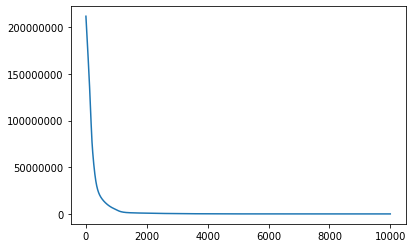

<Figure size 432x288 with 0 Axes>

In [328]:
ax = plt.gca()
plt.plot(np.arange(0,len(np_loss_history),1),np_loss_history)

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()
plt.savefig('loss_fn_232')

In [314]:
[Sr,Ir,Rr,Dr]= solve_SIRD_discrete(num_times,model.predict(x_trains)[0][:,0],model.predict(x_trains)[0][:,1],model.predict(x_trains)[0][:,2],s0,i0,r0,d0)

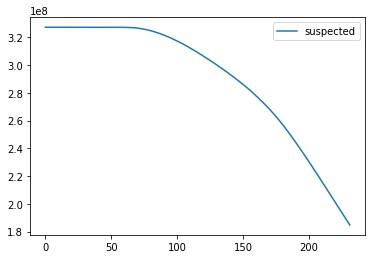

In [315]:
plt.plot(np.arange(num_times),Sr,label="suspected")
plt.legend()

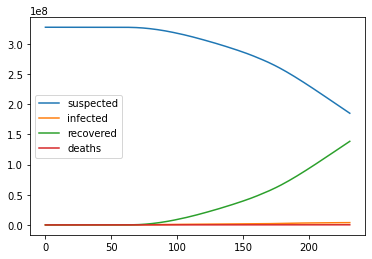

In [316]:
plt.plot(np.arange(num_times),Sr,label="suspected")
plt.plot(np.arange(num_times),Ir,label="infected")
plt.plot(np.arange(num_times),Rr,label="recovered")
plt.plot(np.arange(num_times),Dr,label="deaths")
plt.legend()

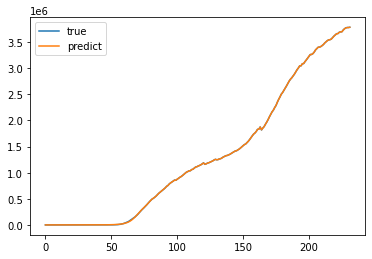

In [317]:
plt.plot(np.arange(0,num_times,1),x_trains[0][:,0],label='true')
plt.plot(np.arange(0,num_times,1),Ir,label='predict')
plt.legend()

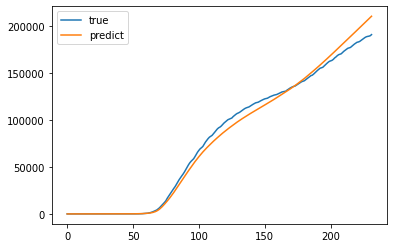

In [318]:
plt.plot(np.arange(0,num_times,1),x_trains[0][:,1],label='true')
plt.plot(np.arange(0,num_times,1),Dr,label='predict')
plt.legend()

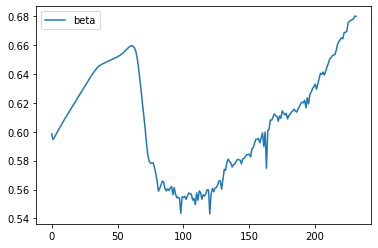

In [319]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,0],label='beta')
plt.legend()

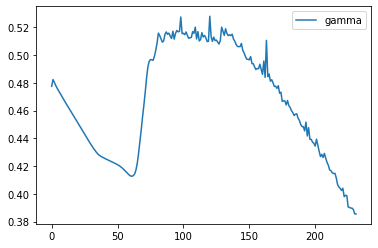

In [320]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,1],label='gamma')
plt.legend()

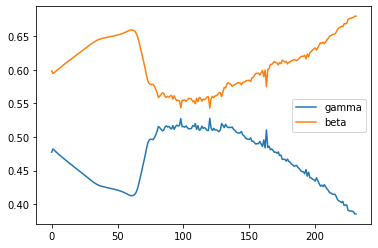

In [321]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,1],label='gamma')
plt.legend()
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,0],label='beta')
plt.legend()

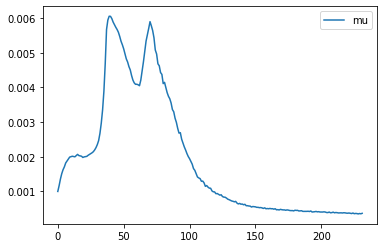

In [322]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,2],label='mu')
plt.legend()

In [324]:
#model.save('2020_09_10_fixed232run')

INFO:tensorflow:Assets written to: 2020_09_10_fixed232run/assets
